In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as wn
wn.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path_root = "/kaggle/input/"
seed = 394

# Dataset Description

* **id**: Unique identifier for each record.
* **CustomerId:** Unique identifier for each customer.
* **Surname:** Last name of the customer.
* **CreditScore:** Credit score of the customer.
* **Geography:** Country where the customer is located (France, Spain, or Germany).
* **Gender:** Gender of the customer (Male or Female).
* **Age:** Age of the customer.
* **Tenure:** Number of years the customer has been with the bank.
* **Balance:** Account balance of the customer.
* **NumOfProducts:** Number of bank products the customer has.
* **HasCrCard:** Whether the customer has a credit card (1 if yes, 0 if no).
* **IsActiveMember:** Whether the customer is an active member (1 if yes, 0 if no).
* **EstimatedSalary:** Estimated salary of the customer.
* **Exited:** Whether the customer has churned (1 if yes, 0 if no)

In [4]:
train_df = pd.read_csv(path_root + "playground-series-s4e1/train.csv")
test_df = pd.read_csv(path_root+"playground-series-s4e1/test.csv")

In [5]:
train_df.shape,test_df.shape

((165034, 14), (110023, 13))

In [6]:
train_df.isnull().sum()*100/train_df.shape[0]

id                 0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [7]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


# Feature Engineering

In [8]:
train_df.drop(['id','Surname','CustomerId'],axis=1,inplace=True)
test_df.drop(['CustomerId','Surname'],axis=1,inplace=True)

In [9]:
train_df['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [10]:
# Check the Correlation between the columns
numerical_train_df = train_df.select_dtypes(include=['float', 'int'])
corr=numerical_train_df.corr()

<Axes: >

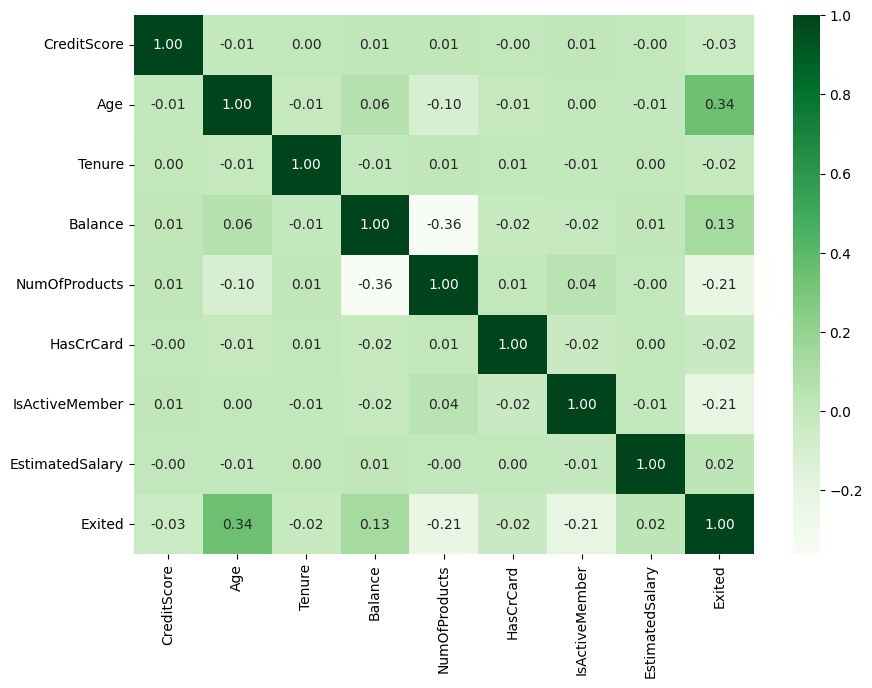

In [11]:
#Draw heatmap for better understandings
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot=True,fmt='.2f',cmap='Greens')

# Data Analysis 

In [12]:
traffic_location_cal = train_df.groupby(['Geography','Gender']).size().unstack()

<Figure size 1000x700 with 0 Axes>

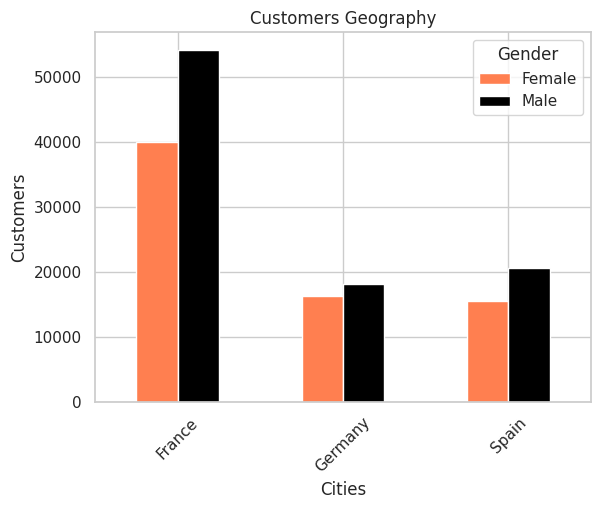

In [13]:
sns.set(style=('whitegrid'))
plt.figure(figsize=(10, 7))
traffic_location_cal.plot(kind='bar',color=['coral','black'])
plt.title('Customers Geography')
plt.xlabel('Cities')
plt.ylabel('Customers')
plt.xticks(rotation=45)
plt.show();

Let's visualize the relationship between "Age" and "CreditScore"

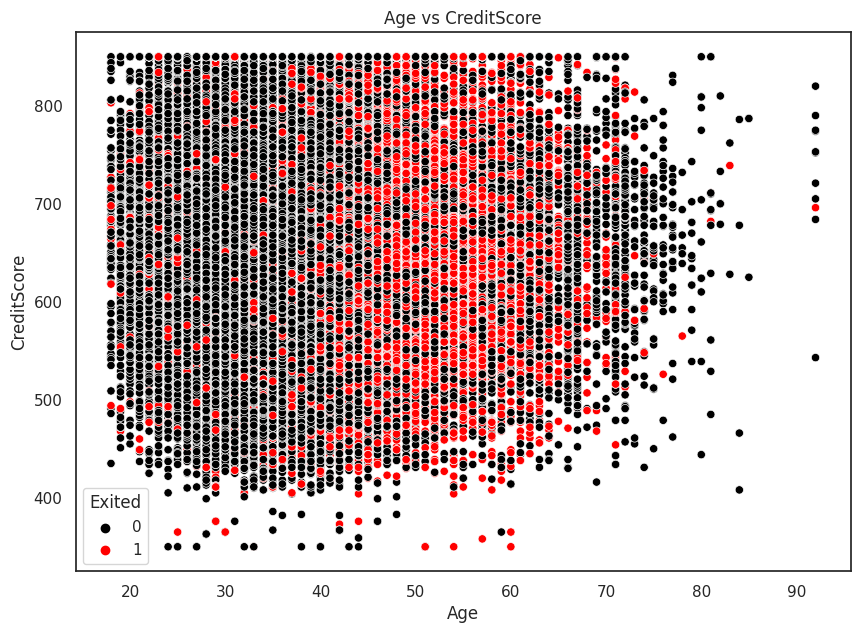

In [14]:
plt.figure(figsize=(10,7))
sns.set(style=('white'))
sns.scatterplot(data=train_df, x="Age", y="CreditScore",
                hue=train_df['Exited'], palette=['black','red'])
plt.title("Age vs CreditScore")
plt.show()

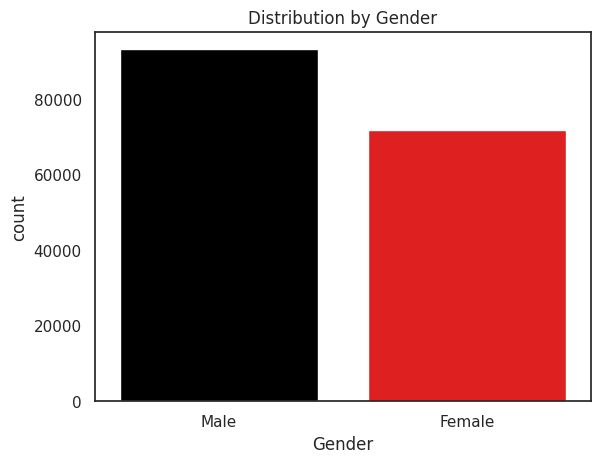

In [15]:
# Distribution by Gender
sns.countplot(data=train_df, x="Gender",palette=['black','red'])
plt.title("Distribution by Gender")
plt.show()

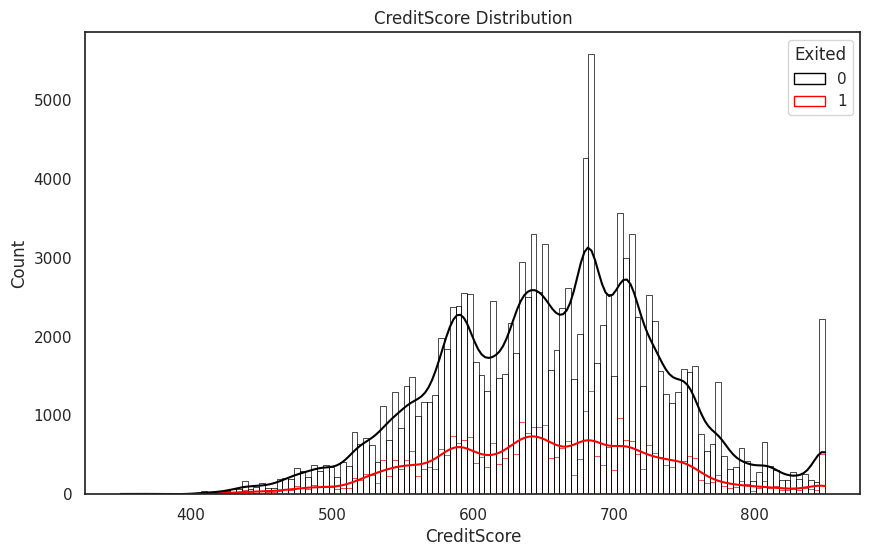

In [16]:
# credit Score Distribution
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x="CreditScore", kde=True,fill=False,
             hue=train_df['Exited'],palette=['black','red'])
plt.title("CreditScore Distribution")
plt.show()

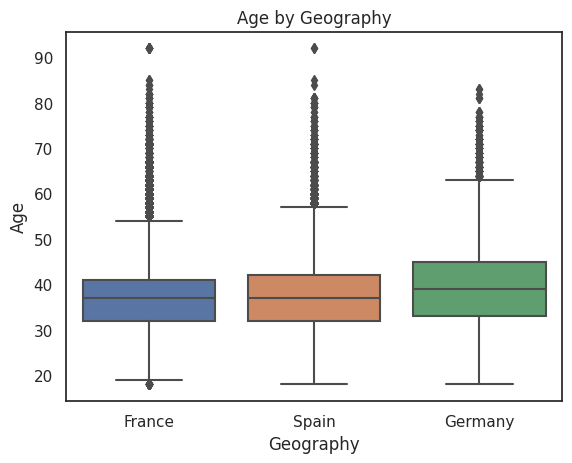

In [17]:
sns.boxplot(data=train_df, x="Geography", y="Age")
plt.title("Age by Geography")
plt.show()

# Data Preprocessing

In [18]:
# now create a Pipeline for prediction
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [19]:
test_df.shape,train_df.shape

((110023, 11), (165034, 11))

In [20]:
x= train_df.drop('Exited',axis=1)
y = train_df['Exited']

In [21]:
x.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83


In [22]:
oneHotEncode_df = ColumnTransformer([
    ('oneHotEncode', OneHotEncoder(handle_unknown='ignore',sparse=False), [1, 2])
], remainder='passthrough')

In [23]:
applyScal = ColumnTransformer([
    ('scalar',MinMaxScaler(),slice(0,13))
],remainder='passthrough')

In [24]:
applyStdScal = ColumnTransformer([
    ('Stdscalar',StandardScaler(),slice(0,12))
],remainder='passthrough')

In [25]:
pipe = Pipeline([
    ('oneHotEncoder',oneHotEncode_df),
    #('MinMaxScaler',applyScal)
    ('StdScaler',applyStdScal)
])

In [26]:
pipe

Pipeline(steps=[('oneHotEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHotEncode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1, 2])])),
                ('StdScaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Stdscalar', StandardScaler(),
                                                  slice(0, 12, None))]))])

In [27]:
scal_df = pipe.fit_transform(x)
scal_df[0]

array([ 8.66991558e-01, -5.15098499e-01, -5.30199018e-01, -8.78465456e-01,
        8.78465456e-01,  1.44134588e-01, -5.78074336e-01, -7.19973392e-01,
       -8.83163300e-01,  8.14297558e-01,  5.71262932e-01, -9.95550213e-01,
        1.81449970e+05])

In [28]:
scal_df.shape,y.shape

((165034, 13), (165034,))

In [29]:
x_train,x_test,y_train,y_test = train_test_split(scal_df,y,test_size=0.2)

In [30]:
x_train.shape,x_test.shape

((132027, 13), (33007, 13))

In [31]:
x_train[0]

array([ 8.66991558e-01, -5.15098499e-01, -5.30199018e-01, -8.78465456e-01,
        8.78465456e-01,  4.68716292e-01, -2.39747972e-01,  3.49106996e-01,
       -8.83163300e-01, -1.01334807e+00,  5.71262932e-01,  1.00446968e+00,
        4.39211500e+04])

In [32]:
# clf = LazyClassifier(ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(x_train, x_test, y_train, y_test)

# Data Modeling

In [33]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

In [34]:
def train_classification_models(x_train, y_train):
    models = {
        'RandomForest': RandomForestClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'NaiveBayes': GaussianNB(),
        'NeuralNetwork': MLPClassifier(),
        'KNeighbors': KNeighborsClassifier(),
        'DecisionTree': DecisionTreeClassifier()
    }

    trained_models = {}
    for name, model in models.items():
        model.fit(x_train, y_train)
        trained_models[name] = model
    return trained_models

In [35]:
trained_models = train_classification_models(x_train,y_train)

In [36]:
trained_models

{'RandomForest': RandomForestClassifier(),
 'GradientBoosting': GradientBoostingClassifier(),
 'NaiveBayes': GaussianNB(),
 'NeuralNetwork': MLPClassifier(),
 'KNeighbors': KNeighborsClassifier(),
 'DecisionTree': DecisionTreeClassifier()}

In [37]:
def evaluate_classification_models(x_test, y_test, trained_models):
    results = []

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, (name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(x_test)
        score = model.score(x_test, y_test)
        cm = confusion_matrix(y_test, y_pred)

        results.append({'model_name': name, 'score': score})

        # Plotting confusion matrix as a heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{name}\nAccuracy: {score:.2f}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(results)
    return results_df

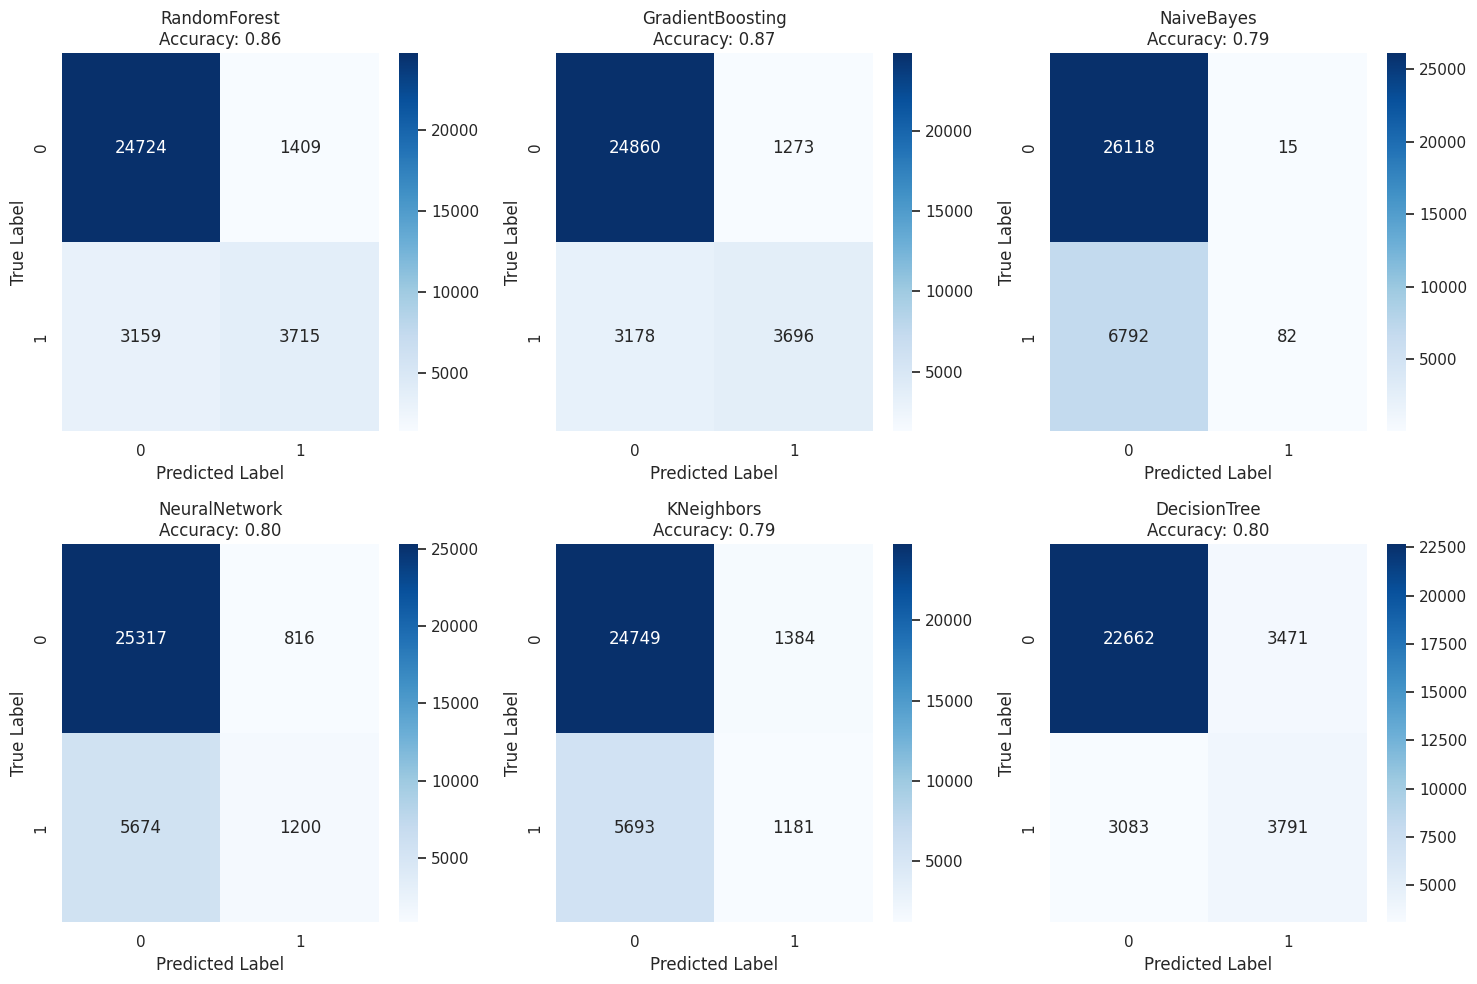

,model_name,score
0,RandomForest,0.861605
1,GradientBoosting,0.865150
2,NaiveBayes,0.793771
3,NeuralNetwork,0.803375
4,KNeighbors,0.785591
5,DecisionTree,0.801436


In [38]:
evaluate_classification_models(x_test,y_test,trained_models)

In [39]:
trained_models['GradientBoosting'].predict_proba(x_test)

array([[0.96607841, 0.03392159],
       [0.89992146, 0.10007854],
       [0.94232144, 0.05767856],
       ...,
       [0.97874425, 0.02125575],
       [0.96154635, 0.03845365],
       [0.33726756, 0.66273244]])

# Predictive Analysis

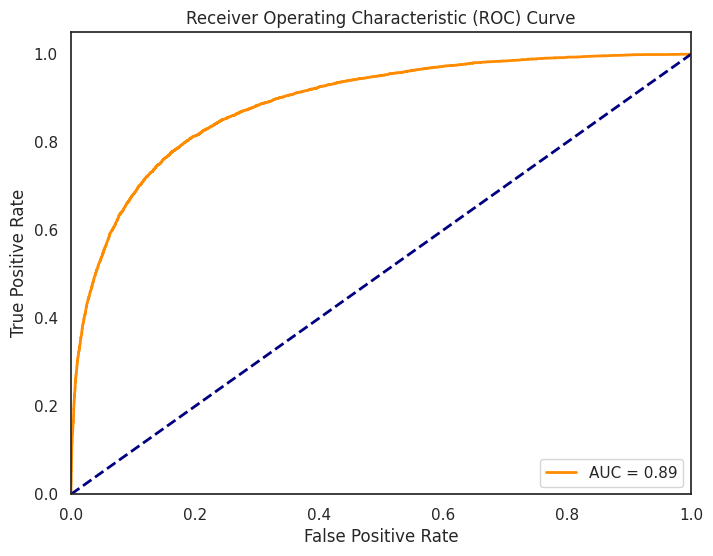

In [40]:
y_probabilities = trained_models['GradientBoosting'].predict_proba(x_test)[:, 1]  # Probabilities of the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Apply Model on Test set

In [41]:
test_df.head()

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [42]:
custId = test_df['id']
custId

0         165034
1         165035
2         165036
3         165037
4         165038
           ...  
110018    275052
110019    275053
110020    275054
110021    275055
110022    275056
Name: id, Length: 110023, dtype: int64

In [43]:
test_ds = test_df.drop('id',axis=1)

In [44]:
test_scaled_ds = pipe.fit_transform(test_ds)

In [45]:
test_predict_prob = trained_models['GradientBoosting'].predict_proba(test_scaled_ds)[:,1]

In [46]:
predict_dict = {'id':custId,'Exited':test_predict_prob}

# Final Submission

In [47]:
final_submission = pd.DataFrame(predict_dict)
final_submission

,id,Exited
0,165034,0.024067
1,165035,0.817067
2,165036,0.033672
3,165037,0.233175
4,165038,0.347695
...,...,...
110018,275052,0.043677
110019,275053,0.082759
110020,275054,0.023511
110021,275055,0.160123


In [48]:
final_submission.to_csv('/kaggle/working/submission.csv', index=False)